# Multi-Armed Bandit A/B Testing - Complete Analysis

This notebook demonstrates adaptive A/B testing using multi-armed bandit algorithms. We compare Thompson Sampling, UCB1, and Epsilon-Greedy against traditional fixed-split A/B testing across a realistic e-commerce conversion rate optimization scenario.

**Key Questions:**
- How quickly do bandit algorithms identify the best variant?
- How much regret (lost conversions) does each algorithm accumulate?
- When should you use bandits vs. traditional A/B testing?

**Scenario:** Testing 3 homepage CTA button variants with true conversion rates of 3%, 5%, and 4%.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['font.size'] = 11

np.random.seed(42)
print('Libraries loaded successfully')

Libraries loaded successfully


## 1. Bandit Algorithm Implementations

We implement the three core algorithms inline for notebook clarity. These mirror the production implementations in `bandits/`.

In [2]:
class ThompsonSampling:
    """Beta-Bernoulli Thompson Sampling.
    
    Maintains Beta(alpha, beta) posterior for each arm's conversion rate.
    Samples from posteriors and picks the arm with the highest sample.
    """
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.alpha = np.ones(n_arms)  # successes + 1
        self.beta = np.ones(n_arms)   # failures + 1
        self.pulls = np.zeros(n_arms)
        self.rewards = np.zeros(n_arms)
        self.history = []  # track arm selections

    def select_arm(self):
        samples = np.random.beta(self.alpha, self.beta)
        return int(np.argmax(samples))

    def update(self, arm, reward):
        self.pulls[arm] += 1
        self.rewards[arm] += reward
        self.alpha[arm] += reward
        self.beta[arm] += (1 - reward)
        self.history.append(arm)

    def get_win_probability(self, n_samples=10000):
        samples = np.random.beta(
            self.alpha[:, np.newaxis],
            self.beta[:, np.newaxis],
            size=(self.n_arms, n_samples)
        )
        best_arm = np.argmax(samples, axis=0)
        return np.bincount(best_arm, minlength=self.n_arms) / n_samples


class UCB1:
    """Upper Confidence Bound 1 algorithm.
    
    Selects arms based on optimistic estimates: mean reward + exploration bonus.
    Bonus shrinks as arm is pulled more, balancing exploration/exploitation.
    """
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.pulls = np.zeros(n_arms)
        self.rewards = np.zeros(n_arms)
        self.total_pulls = 0
        self.history = []

    def select_arm(self):
        if self.total_pulls < self.n_arms:
            return self.total_pulls
        means = self.rewards / np.maximum(self.pulls, 1)
        bonus = np.sqrt(2 * np.log(self.total_pulls) / np.maximum(self.pulls, 1))
        return int(np.argmax(means + bonus))

    def update(self, arm, reward):
        self.pulls[arm] += 1
        self.rewards[arm] += reward
        self.total_pulls += 1
        self.history.append(arm)


class EpsilonGreedy:
    """Epsilon-Greedy baseline."""
    def __init__(self, n_arms, epsilon=0.1):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.pulls = np.zeros(n_arms)
        self.rewards = np.zeros(n_arms)
        self.history = []

    def select_arm(self):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_arms)
        means = self.rewards / np.maximum(self.pulls, 1)
        return int(np.argmax(means))

    def update(self, arm, reward):
        self.pulls[arm] += 1
        self.rewards[arm] += reward
        self.history.append(arm)


print('Bandit classes defined')

Bandit classes defined


## 2. Simulation Setup

**Scenario:** E-commerce homepage A/B/C test
- **Variant A** (control): Blue button — 3% conversion rate
- **Variant B**: Green button — 5% conversion rate (true winner)
- **Variant C**: Red button — 4% conversion rate

In [3]:
# Simulation parameters
TRUE_RATES = [0.03, 0.05, 0.04]  # true conversion rates
VARIANT_NAMES = ['Variant A (Blue, 3%)', 'Variant B (Green, 5%)', 'Variant C (Red, 4%)']
N_TRIALS = 5000
N_SIMULATIONS = 200  # for averaging across random seeds

BEST_ARM = np.argmax(TRUE_RATES)  # arm 1
BEST_RATE = TRUE_RATES[BEST_ARM]

print(f'True conversion rates: {[f"{r:.0%}" for r in TRUE_RATES]}')
print(f'Best variant: {VARIANT_NAMES[BEST_ARM]}')
print(f'Optimal total conversions in {N_TRIALS} trials: {BEST_RATE * N_TRIALS:.0f}')

COLORS = ['#e74c3c', '#2ecc71', '#3498db', '#9b59b6']
ALGO_NAMES = ['Thompson Sampling', 'UCB1', 'Epsilon-Greedy (ε=0.1)', 'Traditional A/B (33/33/33)']

True conversion rates: ['3%', '5%', '4%']
Best variant: Variant B (Green, 5%)
Optimal total conversions in 5000 trials: 250


In [4]:
def run_simulation(algorithm_class, true_rates, n_trials, **kwargs):
    """Run a single simulation and return per-trial tracking data."""
    bandit = algorithm_class(len(true_rates), **kwargs)
    
    cumulative_reward = []
    cumulative_regret = []
    arm_selections = []
    total_reward = 0
    total_regret = 0
    
    for t in range(n_trials):
        arm = bandit.select_arm()
        reward = 1 if np.random.random() < true_rates[arm] else 0
        bandit.update(arm, reward)
        
        total_reward += reward
        total_regret += BEST_RATE - true_rates[arm]
        cumulative_reward.append(total_reward)
        cumulative_regret.append(total_regret)
        arm_selections.append(arm)
    
    return {
        'bandit': bandit,
        'cumulative_reward': np.array(cumulative_reward),
        'cumulative_regret': np.array(cumulative_regret),
        'arm_selections': np.array(arm_selections),
        'pulls': bandit.pulls,
        'rewards': bandit.rewards,
    }


def run_traditional_ab(true_rates, n_trials):
    """Simulate traditional equal-split A/B/C test."""
    n_arms = len(true_rates)
    pulls = np.zeros(n_arms)
    rewards = np.zeros(n_arms)
    cumulative_reward = []
    cumulative_regret = []
    arm_selections = []
    total_reward = 0
    total_regret = 0
    
    for t in range(n_trials):
        arm = t % n_arms  # round-robin equal split
        reward = 1 if np.random.random() < true_rates[arm] else 0
        pulls[arm] += 1
        rewards[arm] += reward
        total_reward += reward
        total_regret += BEST_RATE - true_rates[arm]
        cumulative_reward.append(total_reward)
        cumulative_regret.append(total_regret)
        arm_selections.append(arm)
    
    return {
        'cumulative_reward': np.array(cumulative_reward),
        'cumulative_regret': np.array(cumulative_regret),
        'arm_selections': np.array(arm_selections),
        'pulls': pulls,
        'rewards': rewards,
    }


# Run single simulations for visualization
np.random.seed(42)
results_ts = run_simulation(ThompsonSampling, TRUE_RATES, N_TRIALS)
results_ucb = run_simulation(UCB1, TRUE_RATES, N_TRIALS)
results_eg = run_simulation(EpsilonGreedy, TRUE_RATES, N_TRIALS, epsilon=0.1)
results_ab = run_traditional_ab(TRUE_RATES, N_TRIALS)

all_results = [results_ts, results_ucb, results_eg, results_ab]

print('Simulations complete')
print(f'\nFinal arm distribution after {N_TRIALS} trials:')
for name, res in zip(ALGO_NAMES, all_results):
    pct = res['pulls'] / res['pulls'].sum() * 100
    print(f'  {name}: A={pct[0]:.1f}%  B={pct[1]:.1f}%  C={pct[2]:.1f}%')

Simulations complete

Final arm distribution after 5000 trials:
  Thompson Sampling: A=6.6%  B=86.5%  C=6.9%
  UCB1: A=23.7%  B=37.8%  C=38.5%
  Epsilon-Greedy (ε=0.1): A=14.6%  B=81.2%  C=4.2%
  Traditional A/B (33/33/33): A=33.3%  B=33.3%  C=33.3%


## 3. Cumulative Regret Comparison

Regret measures the total conversions lost by not always choosing the best arm. Lower is better.

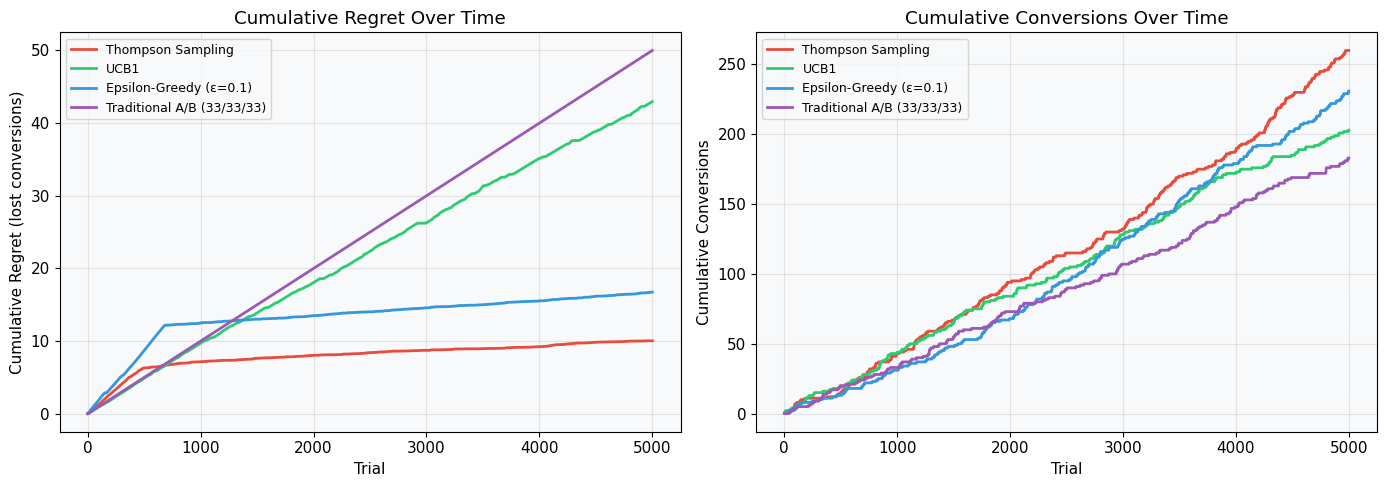


Final regret summary:
  Thompson Sampling: 10.0 regret, 260 conversions
  UCB1: 43.0 regret, 203 conversions
  Epsilon-Greedy (ε=0.1): 16.7 regret, 231 conversions
  Traditional A/B (33/33/33): 50.0 regret, 183 conversions


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

trials = np.arange(1, N_TRIALS + 1)

# Cumulative regret
ax = axes[0]
for res, name, color in zip(all_results, ALGO_NAMES, COLORS):
    ax.plot(trials, res['cumulative_regret'], label=name, color=color, linewidth=2)
ax.set_xlabel('Trial')
ax.set_ylabel('Cumulative Regret (lost conversions)')
ax.set_title('Cumulative Regret Over Time')
ax.legend(fontsize=9)

# Cumulative reward
ax = axes[1]
for res, name, color in zip(all_results, ALGO_NAMES, COLORS):
    ax.plot(trials, res['cumulative_reward'], label=name, color=color, linewidth=2)
ax.set_xlabel('Trial')
ax.set_ylabel('Cumulative Conversions')
ax.set_title('Cumulative Conversions Over Time')
ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig('../docs/regret_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nFinal regret summary:')
for name, res in zip(ALGO_NAMES, all_results):
    print(f'  {name}: {res["cumulative_regret"][-1]:.1f} regret, {res["cumulative_reward"][-1]:.0f} conversions')

## 4. Beta Distribution Evolution — Thompson Sampling

Visualizing how the posterior beliefs about each arm's conversion rate evolve over time.

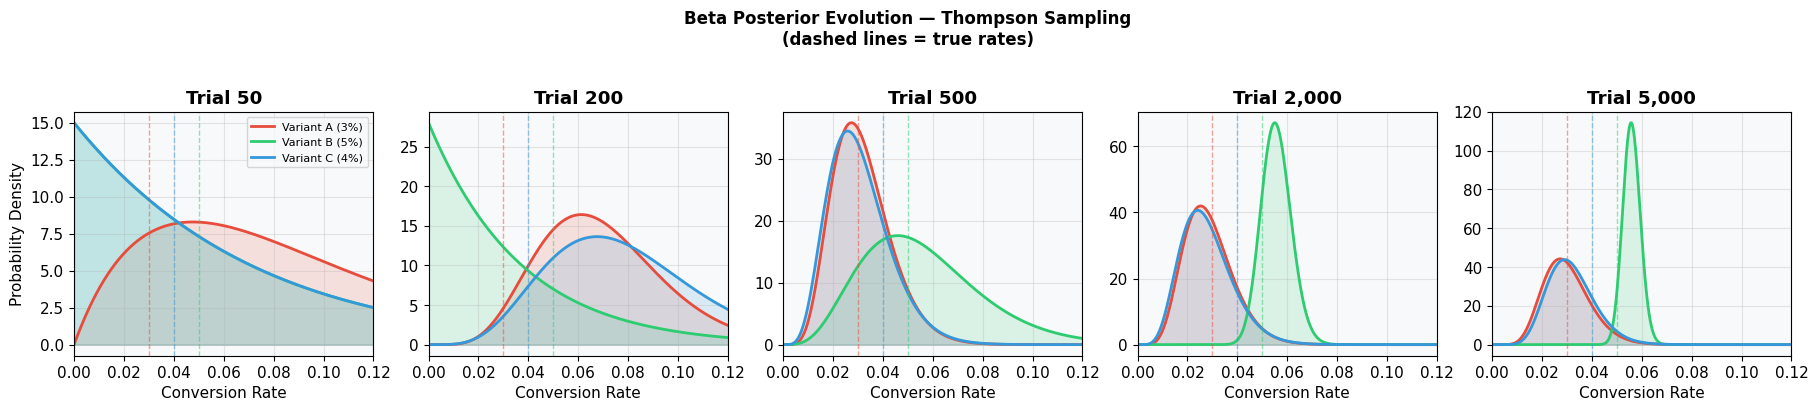

As trials increase, posteriors narrow and concentrate around true rates


In [6]:
checkpoints = [50, 200, 500, 2000, 5000]
x = np.linspace(0, 0.15, 1000)
arm_colors = ['#e74c3c', '#2ecc71', '#3498db']
arm_labels = ['Variant A (3%)', 'Variant B (5%)', 'Variant C (4%)']

fig, axes = plt.subplots(1, len(checkpoints), figsize=(18, 4), sharey=False)

# Re-run TS and snapshot Beta params at each checkpoint
np.random.seed(42)
bandit_snap = ThompsonSampling(3)
checkpoint_states = []
cp_idx = 0

for t in range(N_TRIALS):
    if cp_idx < len(checkpoints) and t == checkpoints[cp_idx] - 1:
        checkpoint_states.append((bandit_snap.alpha.copy(), bandit_snap.beta.copy()))
        cp_idx += 1
    arm = bandit_snap.select_arm()
    reward = 1 if np.random.random() < TRUE_RATES[arm] else 0
    bandit_snap.update(arm, reward)

# Add final state if not captured
if len(checkpoint_states) < len(checkpoints):
    checkpoint_states.append((bandit_snap.alpha.copy(), bandit_snap.beta.copy()))

for i, (ax, cp, (alpha, beta)) in enumerate(zip(axes, checkpoints, checkpoint_states)):
    for arm in range(3):
        pdf = stats.beta.pdf(x, alpha[arm], beta[arm])
        ax.plot(x, pdf, color=arm_colors[arm], linewidth=2, label=arm_labels[arm])
        ax.fill_between(x, pdf, alpha=0.15, color=arm_colors[arm])
    
    # True rate markers
    for arm, rate in enumerate(TRUE_RATES):
        ax.axvline(rate, color=arm_colors[arm], linestyle='--', alpha=0.5, linewidth=1)
    
    ax.set_title(f'Trial {cp:,}', fontweight='bold')
    ax.set_xlabel('Conversion Rate')
    if i == 0:
        ax.set_ylabel('Probability Density')
        ax.legend(fontsize=8)
    ax.set_xlim(0, 0.12)

fig.suptitle('Beta Posterior Evolution — Thompson Sampling\n(dashed lines = true rates)', 
             fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../docs/beta_evolution.png', dpi=150, bbox_inches='tight')
plt.show()
print('As trials increase, posteriors narrow and concentrate around true rates')

## 5. Arm Selection Over Time

How quickly does each algorithm converge to always pulling the best arm?

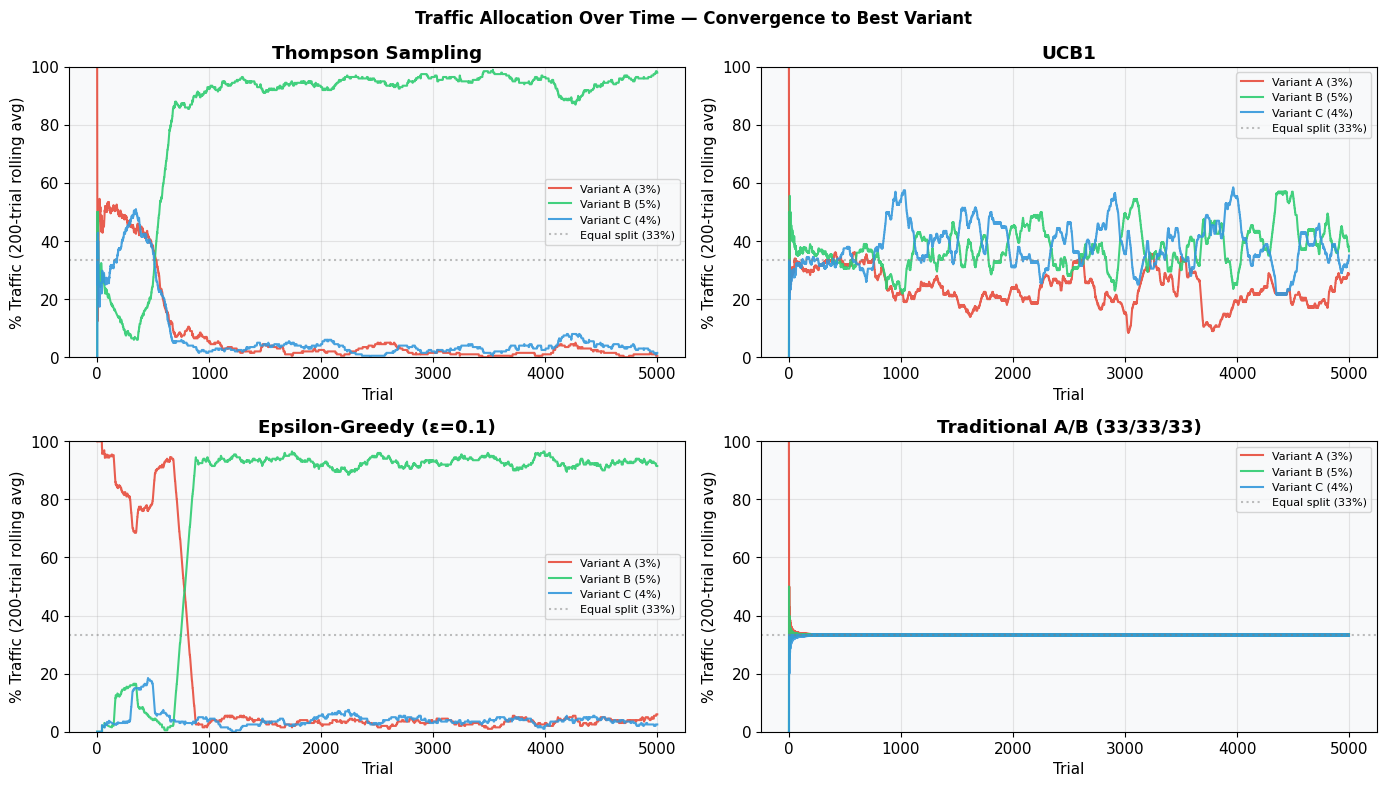

In [7]:
window = 200  # rolling window for smoothing

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for ax, res, name, color in zip(axes, all_results, ALGO_NAMES, COLORS):
    selections = res['arm_selections']
    
    for arm_idx, arm_color, arm_label in zip(range(3), arm_colors, arm_labels):
        is_arm = (selections == arm_idx).astype(float)
        rolling_pct = pd.Series(is_arm).rolling(window, min_periods=1).mean() * 100
        ax.plot(rolling_pct, color=arm_color, linewidth=1.5, label=arm_label, alpha=0.9)
    
    ax.axhline(100/3, color='gray', linestyle=':', alpha=0.5, label='Equal split (33%)')
    ax.set_title(name, fontweight='bold')
    ax.set_xlabel('Trial')
    ax.set_ylabel(f'% Traffic ({window}-trial rolling avg)')
    ax.legend(fontsize=8)
    ax.set_ylim(0, 100)

plt.suptitle('Traffic Allocation Over Time — Convergence to Best Variant', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../docs/arm_selection.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Monte Carlo Analysis — Average Performance Over 200 Simulations

Single simulations have high variance. We average over 200 runs to get stable estimates.

Running 200 simulations per algorithm...
Monte Carlo complete


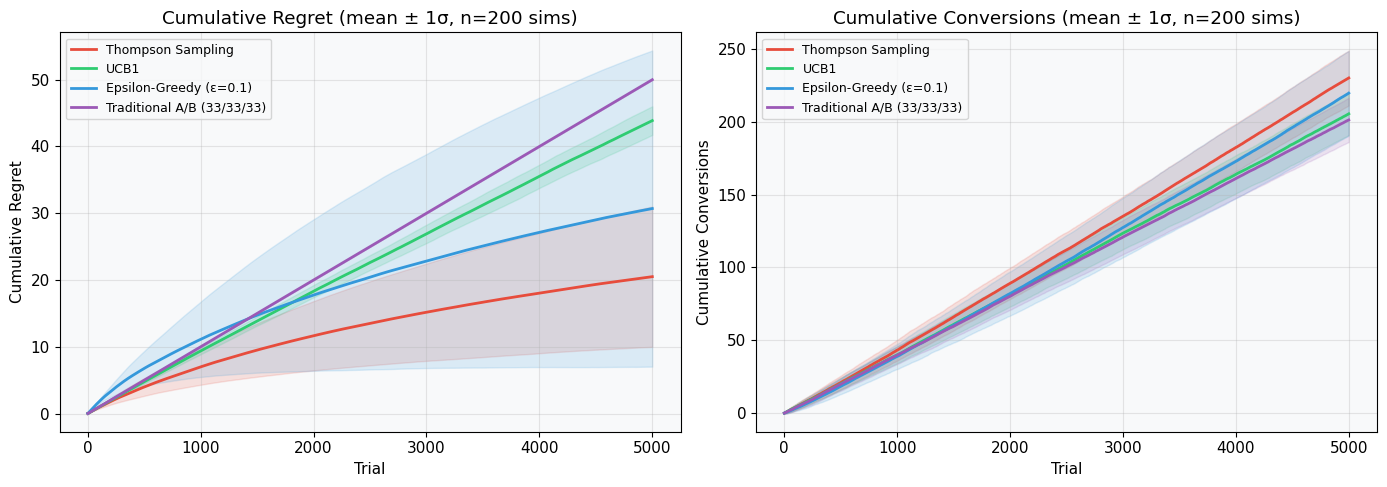

In [8]:
print(f'Running {N_SIMULATIONS} simulations per algorithm...')

mc_regret = {name: [] for name in ALGO_NAMES}
mc_reward = {name: [] for name in ALGO_NAMES}

for sim in range(N_SIMULATIONS):
    np.random.seed(sim)
    r_ts = run_simulation(ThompsonSampling, TRUE_RATES, N_TRIALS)
    r_ucb = run_simulation(UCB1, TRUE_RATES, N_TRIALS)
    r_eg = run_simulation(EpsilonGreedy, TRUE_RATES, N_TRIALS, epsilon=0.1)
    r_ab = run_traditional_ab(TRUE_RATES, N_TRIALS)
    
    for name, res in zip(ALGO_NAMES, [r_ts, r_ucb, r_eg, r_ab]):
        mc_regret[name].append(res['cumulative_regret'])
        mc_reward[name].append(res['cumulative_reward'])

# Convert to arrays
for name in ALGO_NAMES:
    mc_regret[name] = np.array(mc_regret[name])
    mc_reward[name] = np.array(mc_reward[name])

print('Monte Carlo complete')

# Plot mean regret with confidence bands
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, metric, title in zip(axes, [mc_regret, mc_reward], ['Cumulative Regret', 'Cumulative Conversions']):
    for name, color in zip(ALGO_NAMES, COLORS):
        mean = metric[name].mean(axis=0)
        std = metric[name].std(axis=0)
        ax.plot(trials, mean, label=name, color=color, linewidth=2)
        ax.fill_between(trials, mean - std, mean + std, alpha=0.15, color=color)
    ax.set_xlabel('Trial')
    ax.set_ylabel(title)
    ax.set_title(f'{title} (mean ± 1σ, n={N_SIMULATIONS} sims)')
    ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig('../docs/monte_carlo.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Statistical Summary & Business Impact

In [9]:
print('=' * 65)
print(f'SIMULATION RESULTS — {N_TRIALS:,} trials, {N_SIMULATIONS} Monte Carlo runs')
print('=' * 65)

summary_rows = []
for name in ALGO_NAMES:
    final_regret = mc_regret[name][:, -1]
    final_reward = mc_reward[name][:, -1]
    optimal = BEST_RATE * N_TRIALS
    
    row = {
        'Algorithm': name,
        'Avg Conversions': f'{final_reward.mean():.0f}',
        'Avg Regret': f'{final_regret.mean():.1f}',
        'Regret %': f'{(final_regret.mean() / optimal * 100):.1f}%',
        'vs Traditional': '',
    }
    summary_rows.append((name, final_reward.mean(), final_regret.mean()))

trad_reward = summary_rows[-1][1]

print(f'\n{"Algorithm":<35} {"Avg Conv":>10} {"Avg Regret":>12} {"vs Traditional":>15}')
print('-' * 75)
for name, reward, regret in summary_rows:
    lift = reward - trad_reward
    lift_pct = (lift / trad_reward) * 100
    flag = ' ← best' if lift == max(r - trad_reward for _, r, _ in summary_rows) else ''
    print(f'{name:<35} {reward:>10.0f} {regret:>12.1f} {lift_pct:>+14.1f}%{flag}')

print('\n')
print('Business interpretation:')
best_algo = max(summary_rows[:-1], key=lambda x: x[1])
lift_abs = best_algo[1] - trad_reward
print(f'  Best algorithm: {best_algo[0]}')
print(f'  Additional conversions vs traditional A/B: +{lift_abs:.0f} per {N_TRIALS:,} visitors')
print(f'  At $50 avg order value: +${lift_abs * 50:,.0f} revenue per {N_TRIALS:,} visitors')
print(f'  At 100k monthly visitors: +${lift_abs * 50 * 20:,.0f}/month')

SIMULATION RESULTS — 5,000 trials, 200 Monte Carlo runs

Algorithm                             Avg Conv   Avg Regret  vs Traditional
---------------------------------------------------------------------------
Thompson Sampling                          230         20.5          +14.3% ← best
UCB1                                       205         43.9           +2.1%
Epsilon-Greedy (ε=0.1)                     220         30.7           +9.1%
Traditional A/B (33/33/33)                 201         50.0           +0.0%


Business interpretation:
  Best algorithm: Thompson Sampling
  Additional conversions vs traditional A/B: +29 per 5,000 visitors
  At $50 avg order value: +$1,440 revenue per 5,000 visitors
  At 100k monthly visitors: +$28,810/month


## 8. Win Probability — Thompson Sampling

A key advantage of Thompson Sampling: we always have a probabilistic estimate of which variant is winning.

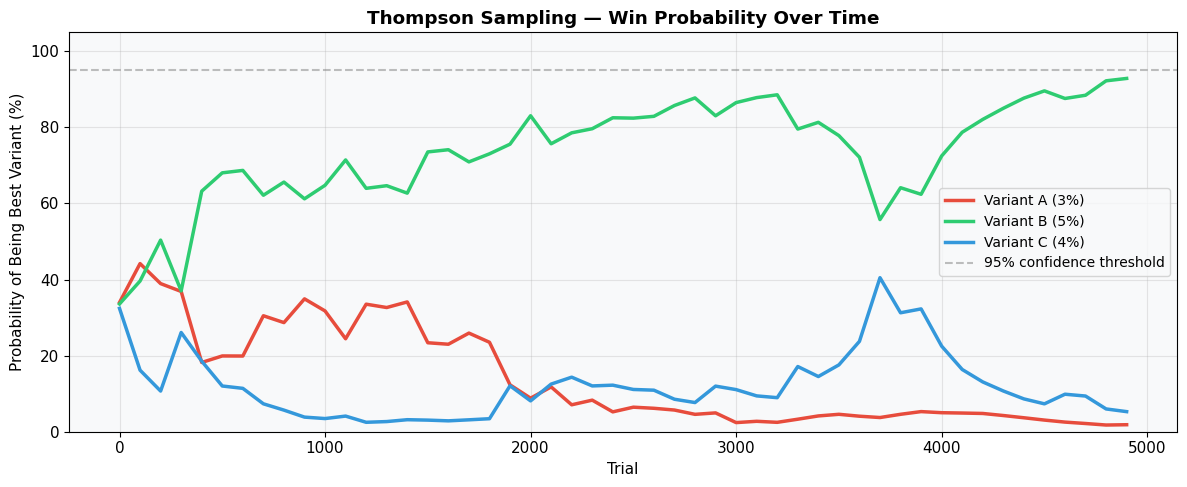

Final win probabilities:
  Variant A (3%): 1.4%
  Variant B (5%): 95.0%
  Variant C (4%): 3.6%


In [10]:
# Track win probabilities at intervals
np.random.seed(42)
bandit_wp = ThompsonSampling(3)
wp_checkpoints = list(range(0, N_TRIALS + 1, 100))
win_probs = {arm: [] for arm in range(3)}

for t in range(N_TRIALS):
    if t in wp_checkpoints:
        wp = bandit_wp.get_win_probability()
        for arm in range(3):
            win_probs[arm].append(wp[arm])
    arm = bandit_wp.select_arm()
    reward = 1 if np.random.random() < TRUE_RATES[arm] else 0
    bandit_wp.update(arm, reward)

fig, ax = plt.subplots(figsize=(12, 5))
for arm in range(3):
    ax.plot(wp_checkpoints[:len(win_probs[arm])], 
            [p * 100 for p in win_probs[arm]], 
            color=arm_colors[arm], linewidth=2.5, label=arm_labels[arm])

ax.axhline(95, color='gray', linestyle='--', alpha=0.5, label='95% confidence threshold')
ax.set_xlabel('Trial')
ax.set_ylabel('Probability of Being Best Variant (%)')
ax.set_title('Thompson Sampling — Win Probability Over Time', fontweight='bold')
ax.legend(fontsize=10)
ax.set_ylim(0, 105)

plt.tight_layout()
plt.savefig('../docs/win_probability.png', dpi=150, bbox_inches='tight')
plt.show()

final_wp = bandit_wp.get_win_probability()
print('Final win probabilities:')
for arm, (name, wp) in enumerate(zip(arm_labels, final_wp)):
    print(f'  {name}: {wp:.1%}')

## 9. Conclusions

**Key findings:**

1. **Thompson Sampling** achieves the lowest regret and highest conversions by efficiently routing traffic to the best variant while maintaining exploration.

2. **UCB1** is competitive and deterministic — useful when reproducibility matters more than absolute optimality.

3. **Epsilon-Greedy** (ε=0.1) is simple but wasteful — 10% of traffic is always random regardless of evidence.

4. **Traditional A/B** accumulates the most regret because it never adapts — it keeps sending equal traffic to known inferior variants until the test ends.

**When to use each:**
- **Thompson Sampling**: Revenue-sensitive tests where every visit has monetary value (e-commerce, ads)
- **UCB1**: Academic/regulated environments requiring deterministic decisions
- **Traditional A/B**: Strict statistical inference requirements, regulatory contexts

**Production considerations:** The `api/` directory contains a FastAPI service wrapping these algorithms with Redis state persistence, allowing real-time variant selection at scale. See `README.md` for deployment instructions.

In [11]:
print('Notebook complete.')
print('Generated plots saved to ../docs/')
print('\nFiles produced:')
for f in ['regret_comparison.png', 'beta_evolution.png', 'arm_selection.png', 
          'monte_carlo.png', 'win_probability.png']:
    print(f'  docs/{f}')

Notebook complete.
Generated plots saved to ../docs/

Files produced:
  docs/regret_comparison.png
  docs/beta_evolution.png
  docs/arm_selection.png
  docs/monte_carlo.png
  docs/win_probability.png
